In [1]:
import QuantLib as ql
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math

from scipy import stats
from scipy.stats import norm
from scipy.optimize import least_squares
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(palette = 'viridis')

# All functions

In [2]:
def bs_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    V = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return V

def vega(S0, K, T, r, sigma):
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

def implied_vol(S0, K, T, r, C0):
    sigma_est = 0.2
    it = 100
    for i in range(it):
        sigma_est -= (bs_call(S0, K, T, r, sigma_est) - C0) / vega(S0, K, T, r, sigma_est)
    return sigma_est

In [3]:
def merton_model(S0, K, T, r, sigma, lambd, m, s):
    
    V = 0
    
    for n in range(80):
        lambd_hat = lambd * (1 + m)
        variance_merton = sigma ** 2 + n * (s ** 2) / T
        sigma_merton = np.sqrt(variance_merton)
        gamma = np.log(1 + m)
        r_merton = r - lambd * m + n * gamma / T
        
        numerator = np.exp(-lambd_hat * T) * (lambd_hat * T) ** n
        denumerator = math.factorial(n)
        factor = numerator / denumerator
            
        V_BS = bs_call(S0, K, T, r_merton, sigma_merton)
        V = V + factor * V_BS
    return V

In [4]:
def heston_model(S0, K, start, end, r, v0, kappa, theta, sigma, rho):
    
    S0 = ql.QuoteHandle(ql.SimpleQuote(S0))
    ql.Settings.instance().evaluationDate = start
    
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, r, ql.Actual365NoLeap()))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, 0, ql.Actual365Fixed()))
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, int(K))
    exercise = ql.EuropeanExercise(end)
    option = ql.VanillaOption(payoff, exercise)

    process = ql.HestonProcess(flat_ts, dividend_ts, S0, v0, kappa, theta, sigma, rho)

    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)

    option.setPricingEngine(engine)

    a = option.NPV()
    return a

In [5]:
def bates_model(S0, K, start, end, r, v0, kappa, theta, sigma, rho, lambd, m, s):
    
    S0 = ql.QuoteHandle(ql.SimpleQuote(S0))
    ql.Settings.instance().evaluationDate = start
    
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, r, ql.Actual365NoLeap()))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(start, 0, ql.Actual365Fixed()))
    payoff = ql.PlainVanillaPayoff(ql.Option.Call, int(K))
    exercise = ql.EuropeanExercise(end)
    option = ql.VanillaOption(payoff, exercise)

    process = ql.BatesProcess(flat_ts, dividend_ts, S0, v0, kappa, theta, sigma, rho, lambd, m, s)

    model = ql.BatesModel(process)
    engine = ql.BatesEngine(model)

    option.setPricingEngine(engine)

    a = option.NPV()
    return a

# Data preprocessing

In [6]:
data = pd.read_excel('data.xlsx', sheet_name = 'All')
data.dropna(inplace = True)
data.set_index('Strike', inplace = True)
data = data.loc[70000:76000]

In [7]:
data.head()

,Price T1,IV T1,Price T2,IV T2,Price T3,IV T3
Strike,,,,,,
70000,4192.0,0.1919,4253.0,0.2085,4487,0.1602
70250,3944.0,0.1881,4014.0,0.2048,4278,0.1602
70500,3698.0,0.1847,3777.0,0.2013,4074,0.1604
70750,3453.0,0.1816,3543.0,0.1979,3875,0.1607
71000,3209.0,0.1788,3312.0,0.1947,3681,0.1611


In [8]:
data.describe()

,Price T1,IV T1,Price T2,IV T2,Price T3,IV T3
count,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000
mean,1719.040000,0.177768,1944.12000,0.189488,2534.440000,0.171260
std,1298.215746,0.007781,1203.58528,0.008647,1028.727048,0.009857
min,192.000000,0.169200,468.00000,0.179800,1164.000000,0.160200
25%,557.000000,0.171200,891.00000,0.181900,1658.000000,0.162400
50%,1424.000000,0.176100,1686.00000,0.187200,2364.000000,0.168900
75%,2730.000000,0.183600,2863.00000,0.195000,3313.000000,0.178700
max,4192.000000,0.193500,4253.00000,0.208500,4487.000000,0.190600


In [9]:
S0 = 73718
T_fut = 41 / 365
start = ql.Date(8, 5, 2020)
end = ql.Date(14, 5, 2020)
T = (end - start) / 365
r = 0.082

implieds = np.array(data['IV T1'])
prices = np.array(data['Price T1'])
strikes = data.index

S0 = S0 * np.exp(-r * T_fut)
print('Future price at t = 0 is {0:.5f}'.format(S0))

Future price at t = 0 is 73042.10413


# Build implied vol curve

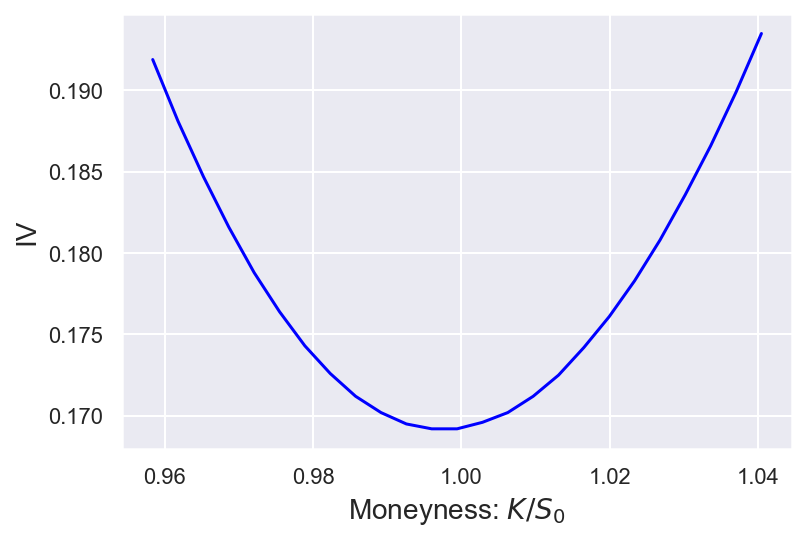

In [10]:
plt.plot(strikes / S0, implieds, color = 'blue')

plt.xlabel('Moneyness: $K / S_{0}$', size = 14)
plt.ylabel('IV', size = 14)

# plt.savefig('Single model pictures/IV.pdf')
plt.show()

# Models calibration

## Calibrate Merton model

In [11]:
def single_optimizer(parms):
    sigma, lambd, m, s = parms
    
    answer = np.zeros(len(strikes), dtype = np.float64)
    
    for i, j in enumerate(strikes):
        answer[i] = implieds[i] - implied_vol(S0, j, T, r, \
                                                     merton_model(S0, j, T, r, \
                                                                  sigma, lambd, m, s))
            
    return answer

In [12]:
%%time
initial_guess = (0.1, 0.1, 0.1, 0.1)

opt_params = least_squares(single_optimizer, x0 = initial_guess, \
                           bounds = ((0, 0, 0, 0), (np.infty, np.infty, np.infty, np.infty)), \
                           method = 'trf', verbose = 2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.9517e-02                                    1.11e+00    
       1              2         2.1202e-04      4.93e-02       2.00e-01       8.66e-03    
       2              3         3.6472e-05      1.76e-04       6.45e-02       9.71e-04    
       3              5         3.4480e-05      1.99e-06       9.51e-02       2.03e-02    
       4              6         1.8107e-05      1.64e-05       1.51e-02       1.95e-05    
       5              7         1.7928e-05      1.79e-07       2.57e-02       1.59e-03    
       6              9         1.7736e-05      1.92e-07       1.19e-02       3.10e-04    
       7             10         1.7591e-05      1.45e-07       2.38e-02       1.31e-03    
       8             11         1.7374e-05      2.17e-07       2.38e-02       1.19e-03    
       9             13         1.7219e-05      1.55e-07       1.19e-02       2.60e-04    

In [13]:
print('sigma = %f, lambd = %f, m = %f, s = %f' % (opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3]))

sigma = 0.139708, lambd = 17.102114, m = 0.002143, s = 0.026470


### Use calibrated parameters to calculate Merton's call price

In [14]:
mertons_single = np.zeros(len(strikes))

for i, j in enumerate(strikes):
    mertons_single[i] = merton_model(S0, j, T, r, \
                                     opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3])

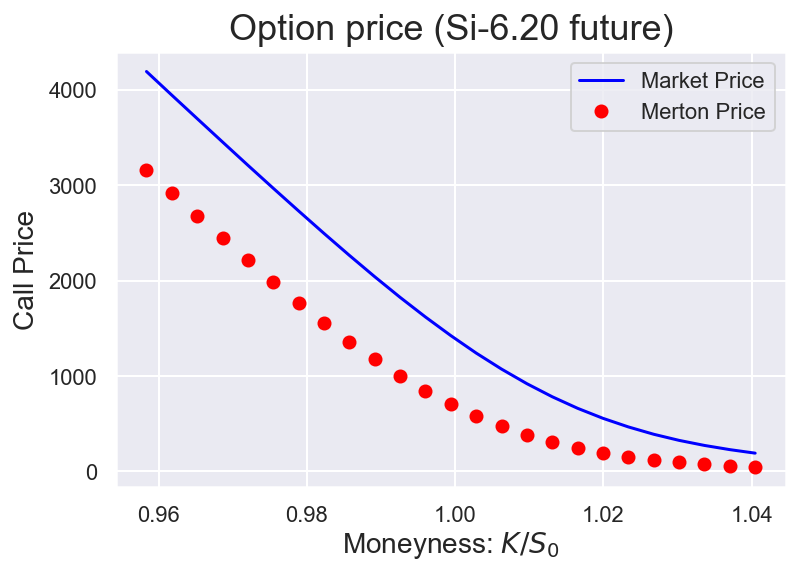

In [15]:
plt.plot(strikes / S0, prices, color = 'blue', label = 'Market Price')
plt.plot(strikes / S0, mertons_single, color = 'red', linestyle = ' ', marker = 'o', label = 'Merton Price')

plt.title('Option price (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('Call Price', size = 14)
plt.legend()

# plt.savefig('Single model pictures/Merton single price.pdf')
plt.show()

In [16]:
mse = mean_squared_error(mertons_single, prices)
mae = mean_absolute_error(mertons_single, prices)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 527900.80037
MAE: 656.39067


### From calibrated Merton's call price extract implied volatility

In [17]:
mertons_single_iv = np.zeros(len(strikes))

for i, j in enumerate(strikes):
    mertons_single_iv[i] = implied_vol(S0, j, T, r, mertons_single[i])

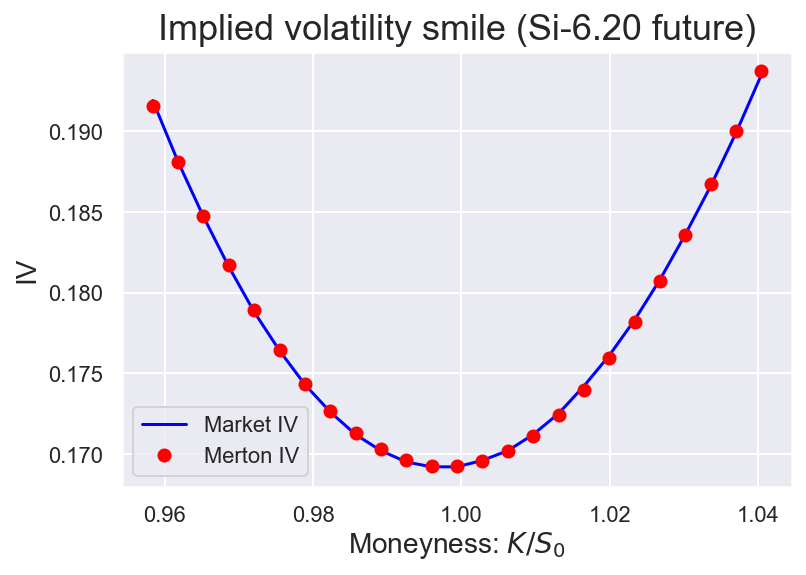

In [18]:
plt.plot(strikes / S0, implieds, color = 'blue', label = 'Market IV')
plt.plot(strikes / S0, mertons_single_iv, color = 'red', linestyle = ' ', marker = 'o', label = 'Merton IV')

plt.title('Implied volatility smile (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('IV', size = 14)
plt.legend()

# plt.savefig('Single model pictures/Merton single iv.pdf')
plt.show()

In [19]:
mse = mean_squared_error(mertons_single_iv, implieds)
mae = mean_absolute_error(mertons_single_iv, implieds)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 0.00000
MAE: 0.00009


### Monte Carlo with best parameters

In [20]:
sigma = opt_params.x[0]
lambd = opt_params.x[1]
m = opt_params.x[2]
s = opt_params.x[3]

In [21]:
np.random.seed(22)

M = 252
I = 10000
dt = T_fut / M
rj = lambd * (np.exp(m + 0.5 * s ** 2) - 1)
S = np.zeros((M + 1, I))
S[0] = S0
sn1 = np.random.standard_normal((M + 1, I))
sn2 = np.random.standard_normal((M + 1, I))
poi = np.random.poisson(lambd * dt, (M + 1, I))
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sn1[t]) \
                       + (np.exp(m + s * sn2[t]) - 1) * poi[t])
    S[t] = np.maximum(S[t], 0)

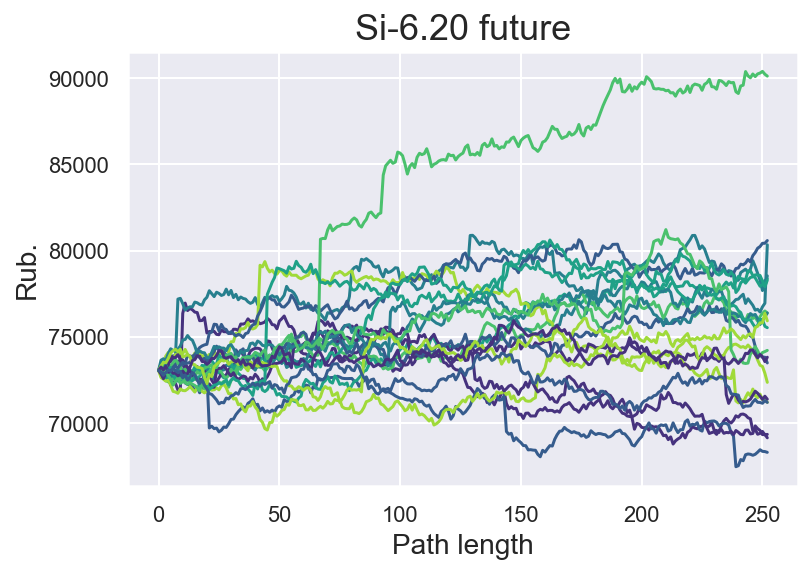

In [22]:
plt.plot(S[:, :20])

plt.title('Si-6.20 future', size = 18)
plt.xlabel('Path length', size = 14)
plt.ylabel('Rub.', size = 14)

# plt.savefig('Single model pictures/Merton single MC.pdf')
plt.show()

In [23]:
error = np.std(S) / np.sqrt(np.mean(S) * I)
print('Error of MC estimator = {0:.5%}'.format(error))

Error of MC estimator = 11.62689%


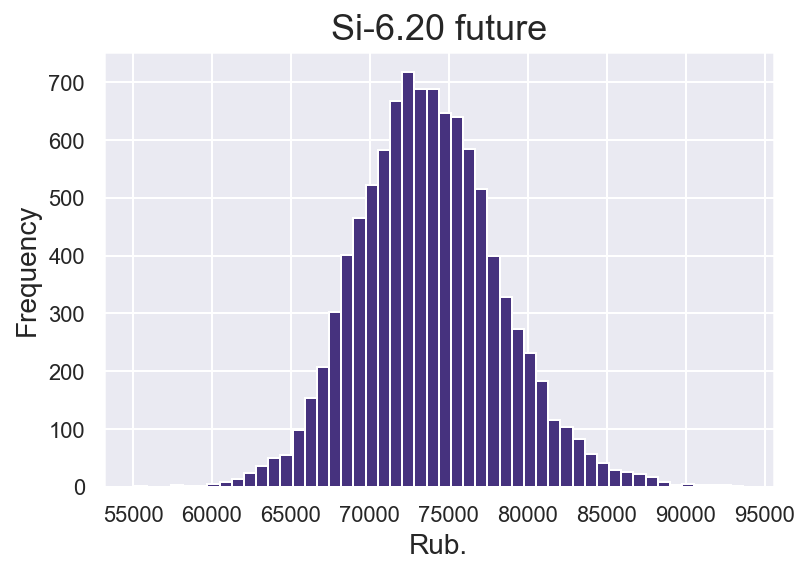

In [24]:
plt.hist(S[-1], bins = 50)

plt.title('Si-6.20 future', size = 18)

plt.xlabel('Rub.', size = 14)
plt.ylabel('Frequency', size = 14)

# plt.savefig('Single model pictures/Merton single price distribution.pdf')
plt.show()

In [25]:
def print_statistics(array):
    sta = sp.stats.describe(array)
    print("%14s %15s" % ('statistic', 'Price'))
    print(30 * "-")
    print("%14s %15.5f" % ('size', sta[0]))
    print("%14s %15.5f" % ('min', sta[1][0]))
    print("%14s %15.5f" % ('max', sta[1][1]))
    print("%14s %15.5f" % ('mean', sta[2]))
    print("%14s %15.5f" % ('std', np.sqrt(sta[3])))
    print("%14s %15.5f" % ('skew', sta[4]))
    print("%14s %15.5f" % ('kurtosis', sta[5]))

In [26]:
print_statistics(S[-1])

     statistic           Price
------------------------------
          size     10000.00000
           min     55087.29651
           max     93631.98381
          mean     73777.71451
           std      4482.89515
          skew         0.27558
      kurtosis         0.40434


## Calibrate Heston model

In [27]:
def single_optimizer(parms):
    v0, kappa, theta, sigma, rho = parms
    
    answer = np.zeros(len(strikes), dtype = np.float64)
    
    for i, j in enumerate(strikes):
        answer[i] = implieds[i] - implied_vol(S0, j, T, r, \
                                                     heston_model(S0, j, start, end, r, \
                                                                  v0, kappa, theta, sigma, rho))
            
    return answer

In [28]:
%%time
initial_guess = (0.1, 0.1, 0.1, 0.1, 0.1)

opt_params = least_squares(single_optimizer, x0 = initial_guess, \
                           bounds = ((0, 0, 0, 0, -1), (np.infty, np.infty, np.infty, np.infty, 1)), \
                           method = 'trf', verbose = 2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4028e-01                                    5.47e-01    
       1              2         3.5383e-02      2.05e-01       5.37e-01       1.52e-01    
       2              3         3.0022e-03      3.24e-02       1.12e+00       3.22e-02    
       3              4         4.0441e-05      2.96e-03       2.30e-01       2.87e-03    
       4              5         8.8151e-06      3.16e-05       3.29e-02       4.79e-05    
       5              7         8.8062e-06      8.95e-09       5.66e-01       1.46e-04    
       6              8         8.7239e-06      8.22e-08       1.13e-01       1.18e-05    
       7             10         8.7023e-06      2.17e-08       3.65e-02       1.95e-05    
       8             11         8.6803e-06      2.20e-08       1.02e-01       8.88e-05    
       9             12         8.6253e-06      5.50e-08       1.32e-01       3.44e-05    

In [29]:
print('v0 = %f, kappa = %f, theta = %f, sigma = %f, rho = %f' % \
      (opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3], opt_params.x[4]))

v0 = 0.000069, kappa = 5.061597, theta = 0.773277, sigma = 2.261522, rho = 0.056929


### Use calibrated parameters to calculate Heston's call price

In [30]:
hestons_single = np.zeros(len(strikes))

for i, j in enumerate(strikes):
    hestons_single[i] = heston_model(S0, j, start, end, r, \
                              opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3], opt_params.x[4])

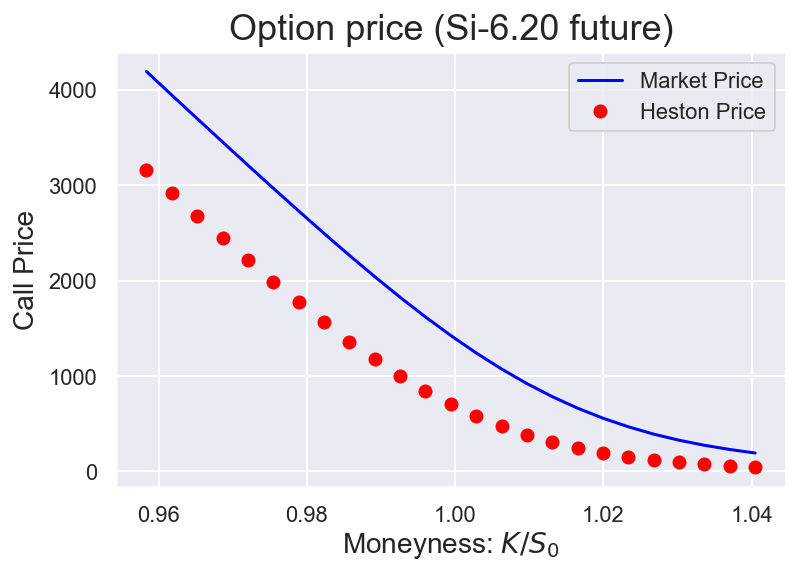

In [31]:
plt.plot(strikes / S0, prices, color = 'blue', label = 'Market Price')
plt.plot(strikes / S0, hestons_single, color = 'red', linestyle = ' ', marker = 'o', label = 'Heston Price')

plt.title('Option price (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('Call Price', size = 14)
plt.legend()

# plt.savefig('Single model pictures/Heston single price.pdf')
plt.show()

In [32]:
mse = mean_squared_error(hestons_single, prices)
mae = mean_absolute_error(hestons_single, prices)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 528010.95350
MAE: 656.46610


### From calibrated Heston's call price extract implied volatility

In [33]:
hestons_single_iv = np.zeros(len(strikes))

for i, j in enumerate(strikes):
    hestons_single_iv[i] = implied_vol(S0, j, T, r, hestons_single[i])

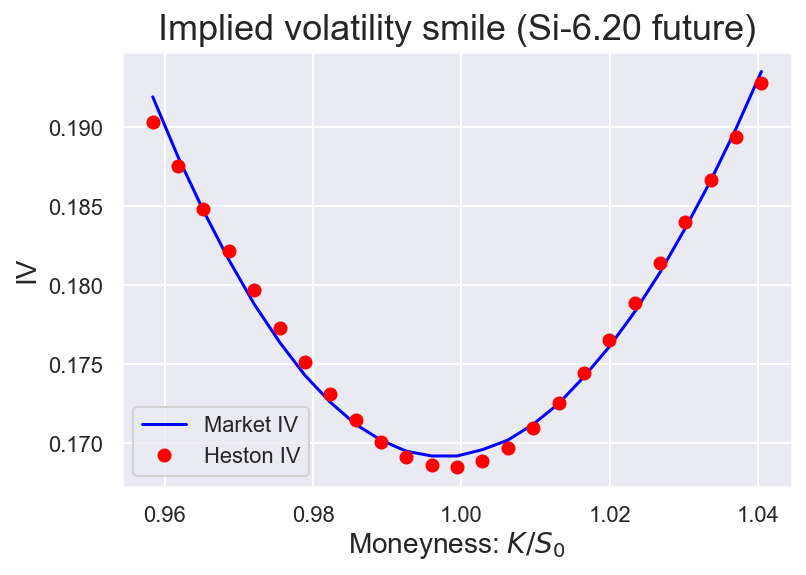

In [34]:
plt.plot(strikes / S0, implieds, color = 'blue', label = 'Market IV')
plt.plot(strikes / S0, hestons_single_iv, color = 'red', linestyle = ' ', marker = 'o', label = 'Heston IV')

plt.title('Implied volatility smile (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('IV', size = 14)
plt.legend()

# plt.savefig('Single model pictures/Heston single iv.pdf')
plt.show()

In [35]:
mse = mean_squared_error(hestons_single_iv, implieds)
mae = mean_absolute_error(hestons_single_iv, implieds)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 0.00000
MAE: 0.00052


### Monte Carlo with best parameters

In [36]:
v0 = opt_params.x[0]
kappa = opt_params.x[1]
theta = opt_params.x[2]
sigma = opt_params.x[3]
rho = opt_params.x[4]

In [37]:
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

In [38]:
np.random.seed(22)

M = 252
I = 10000
ran_num = np.random.standard_normal((2, M + 1, I))
dt = T_fut / M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt \
             + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt) * ran[1])
    v = np.maximum(vh, 0)

In [39]:
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

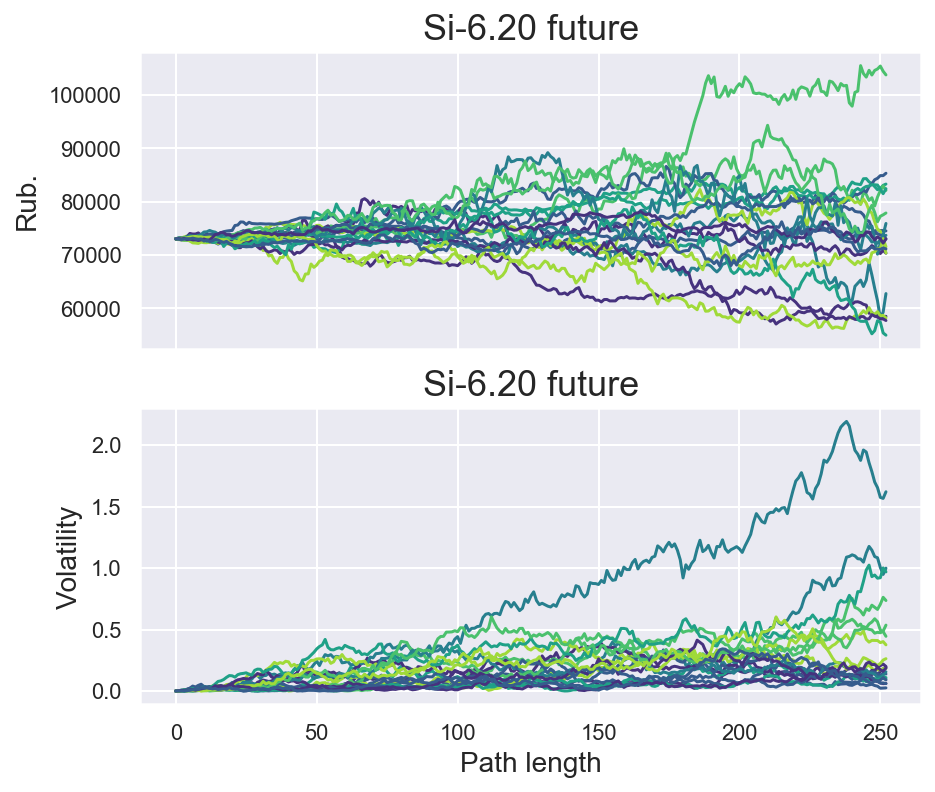

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (7, 6))

ax1.set_title('Si-6.20 future', size = 18)
ax1.plot(S[:, :20])
ax1.set_ylabel('Rub.', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.plot(v[:, :20])
ax2.set_xlabel('Path length', size = 14)
ax2.set_ylabel('Volatility', size = 14)

# plt.savefig('Single model pictures/Heston single MC.pdf')
plt.show()

In [41]:
error = np.std(S) / np.sqrt(np.mean(S) * I)
print('Error of MC estimator = {0:.5%}'.format(error))

Error of MC estimator = 23.72364%


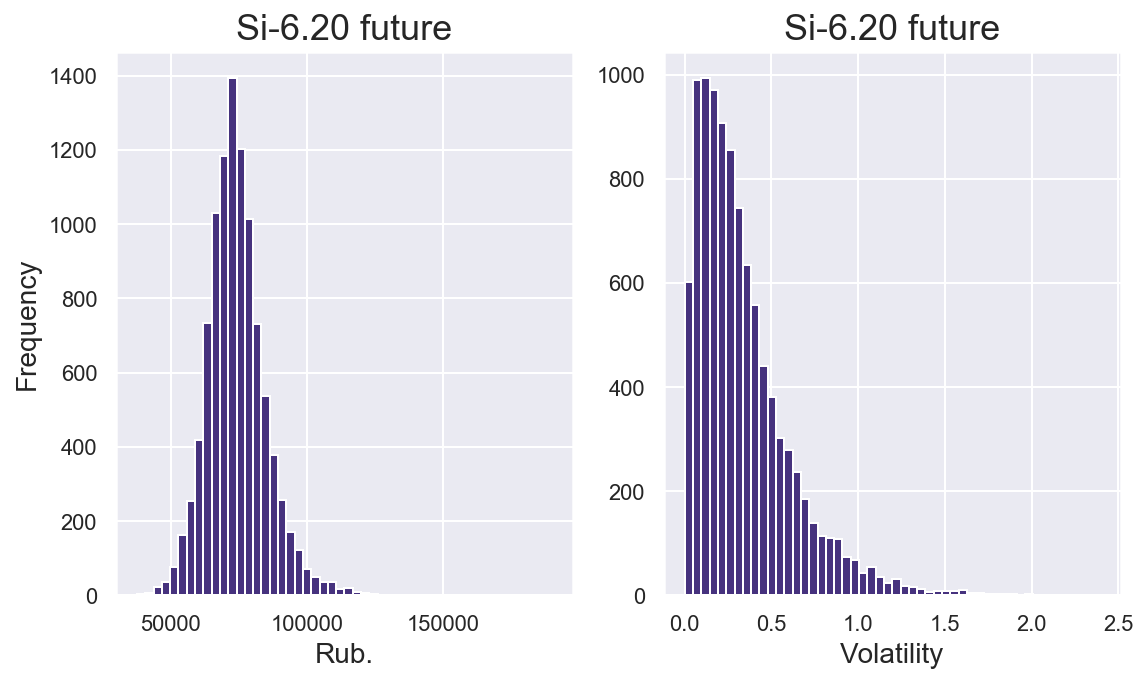

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 5))

ax1.set_title('Si-6.20 future', size = 18)
ax1.hist(S[-1], bins = 50)
ax1.set_xlabel('Rub.', size = 14)
ax1.set_ylabel('Frequency', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.hist(v[-1], bins = 50)
ax2.set_xlabel('Volatility', size = 14)

# plt.savefig('Single model pictures/Heston single price distribution.pdf')
plt.show()

In [43]:
def print_statistics(a1, a2):

    sta1 = sp.stats.describe(a1)
    sta2 = sp.stats.describe(a2)
    print("%14s %14s %14s" % ('statistic', 'Price', 'Volatility'))
    print(45 * "-")
    print("%14s %14.3f %14.3f" % ('size', sta1[0], sta2[0]))
    print("%14s %14.3f %14.3f" % ('min', sta1[1][0], sta2[1][0]))
    print("%14s %14.3f %14.3f" % ('max', sta1[1][1], sta2[1][1]))
    print("%14s %14.3f %14.3f" % ('mean', sta1[2], sta2[2]))
    print("%14s %14.3f %14.3f" % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print("%14s %14.3f %14.3f" % ('skew', sta1[4], sta2[4]))
    print("%14s %14.3f %14.3f" % ('kurtosis', sta1[5], sta2[5]))

In [44]:
print_statistics(S[-1], v[-1])

     statistic          Price     Volatility
---------------------------------------------
          size      10000.000      10000.000
           min      37566.842          0.000
           max     190230.746          2.393
          mean      74426.399          0.338
           std      11029.544          0.274
          skew          0.897          1.666
      kurtosis          3.585          4.016


## Calibrate Bates model

In [45]:
def single_optimizer(parms):
    v0, kappa, theta, sigma, rho, lambd, m, s = parms
    
    answer = np.zeros(len(strikes), dtype = np.float64)
    
    for i, j in enumerate(strikes):
        answer[i] = implieds[i] - implied_vol(S0, j, T, r, \
                                                     bates_model(S0, j, start, end, r, \
                                                                  v0, kappa, theta, sigma, \
                                                                 rho, lambd, m, s))
            
    return answer

In [46]:
%%time
initial_guess = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

opt_params = least_squares(single_optimizer, x0 = initial_guess, \
                           bounds = ((0, 0, 0, 0, -1, 0, 0, 0), (np.infty, np.infty, np.infty, \
                                                                 np.infty, 1, np.infty, np.infty, np.infty)), \
                           method = 'trf', verbose = 2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4623e-01                                    5.52e-01    
       1              2         3.6333e-02      2.10e-01       7.29e-01       1.53e-01    
       2              3         4.1120e-03      3.22e-02       1.56e+00       3.10e-02    
       3              4         7.8379e-05      4.03e-03       7.12e-01       1.87e-03    
       4              5         9.7847e-06      6.86e-05       3.15e+00       4.48e-04    
       5              6         8.1520e-06      1.63e-06       1.74e+00       4.15e-05    
       6              9         8.0798e-06      7.22e-08       3.74e-01       8.52e-05    
       7             10         7.9947e-06      8.50e-08       1.80e+00       2.07e-04    
       8             11         7.5882e-06      4.07e-07       7.47e-01       1.06e-04    
       9             12         7.3213e-06      2.67e-07       7.67e-01       1.65e-02    

In [47]:
print('v0 = %f, kappa = %f, theta = %f, sigma = %f, rho = %f, lambd = %f, m = %f, s = %f' % \
      (opt_params.x[0], opt_params.x[1], opt_params.x[2], opt_params.x[3], opt_params.x[4], \
       opt_params.x[5], opt_params.x[6], opt_params.x[7]))

v0 = 0.000000, kappa = 8.022109, theta = 0.411175, sigma = 1.283240, rho = 0.053726, lambd = 3.486024, m = 0.002513, s = 0.040888


### Use calibrated parameters to calculate Bates's call price

In [48]:
bates_single = np.zeros(len(strikes))

for i, j in enumerate(strikes):
    bates_single[i] = bates_model(S0, j, start, end, r, \
                              opt_params.x[0], opt_params.x[1], opt_params.x[2], \
                                  opt_params.x[3], opt_params.x[4], opt_params.x[5], \
                                  opt_params.x[6], opt_params.x[7])

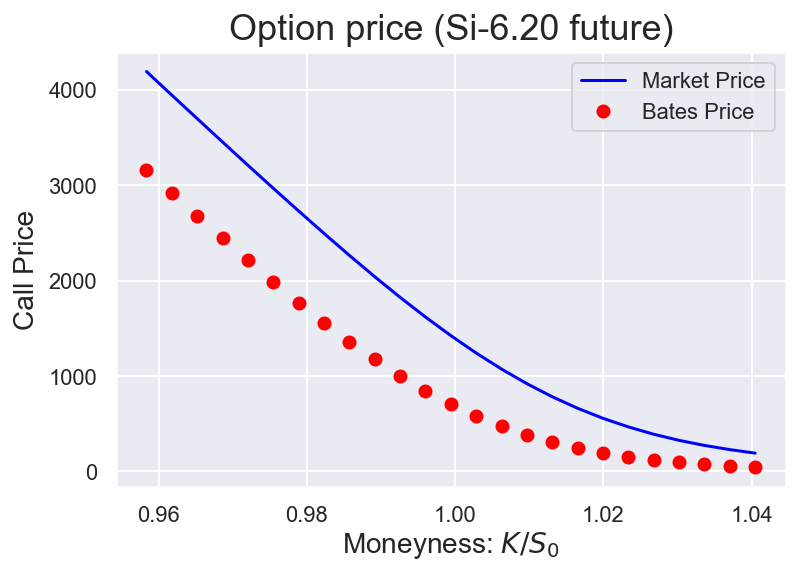

In [49]:
plt.plot(strikes / S0, prices, color = 'blue', label = 'Market Price')
plt.plot(strikes / S0, bates_single, color = 'red', linestyle = ' ', marker = 'o', label = 'Bates Price')

plt.title('Option price (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('Call Price', size = 14)
plt.legend()

# plt.savefig('Single model pictures/Bates single price.pdf')
plt.show()

In [50]:
mse = mean_squared_error(bates_single, prices)
mae = mean_absolute_error(bates_single, prices)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 527945.92058
MAE: 656.38708


### From calibrated Bates's call price extract implied volatility

In [51]:
bates_single_iv = np.zeros(len(strikes))

for i, j in enumerate(strikes):
    bates_single_iv[i] = implied_vol(S0, j, T, r, bates_single[i])

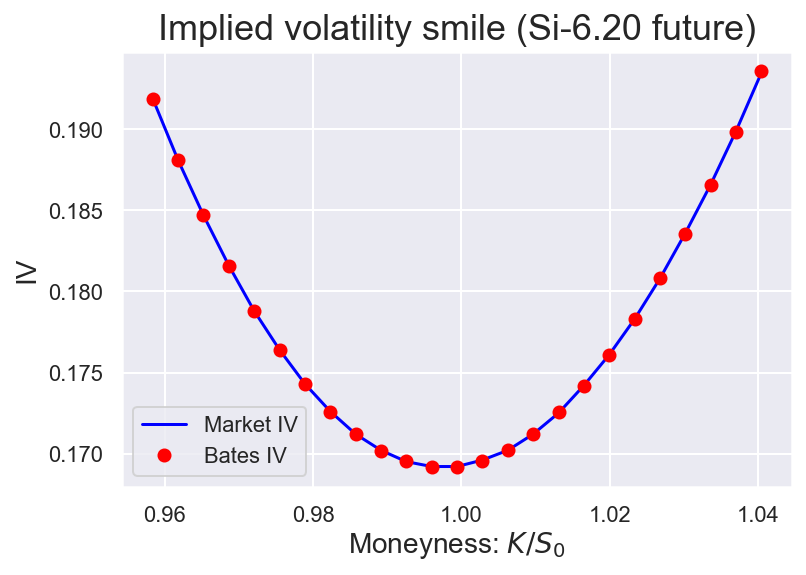

In [52]:
plt.plot(strikes / S0, implieds, color = 'blue', label = 'Market IV')
plt.plot(strikes / S0, bates_single_iv, color = 'red', linestyle = ' ', marker = 'o', label = 'Bates IV')

plt.title('Implied volatility smile (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('IV', size = 14)
plt.legend()

# plt.savefig('Single model pictures/Bates single iv.pdf')
plt.show()

In [53]:
mse = mean_squared_error(bates_single_iv, implieds)
mae = mean_absolute_error(bates_single_iv, implieds)

print('MSE: {0:.5f}'.format(mse))
print('MAE: {0:.5f}'.format(mae))

MSE: 0.00000
MAE: 0.00002


### Monte Carlo with best parameters

In [54]:
v0 = opt_params.x[0]
kappa = opt_params.x[1]
theta = opt_params.x[2]
sigma = opt_params.x[3]
rho = opt_params.x[4]

lambd = opt_params.x[5]
m = opt_params.x[6]
s = opt_params.x[7]

In [55]:
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

In [56]:
np.random.seed(22)

M = 252
I = 10000
ran_num = np.random.standard_normal((2, M + 1, I))
dt = T_fut / M
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    vh[t] = (vh[t - 1] + kappa * (theta - np.maximum(vh[t - 1], 0)) * dt \
             + sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * np.sqrt(dt) * ran[1])
    v = np.maximum(vh, 0)

In [57]:
sn2 = np.random.standard_normal((M + 1, I))
poi = np.random.poisson(lambd * dt, (M + 1, I))

rj = lambd * (np.exp(m + 0.5 * s ** 2) - 1)
S = np.zeros_like(ran_num[0])
S[0] = S0

for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * v[t]) * dt + np.sqrt(v[t]) * np.sqrt(dt) * ran[0]) \
                       + (np.exp(m + s * sn2[t]) - 1) * poi[t])
    S[t] = np.maximum(S[t], 0)

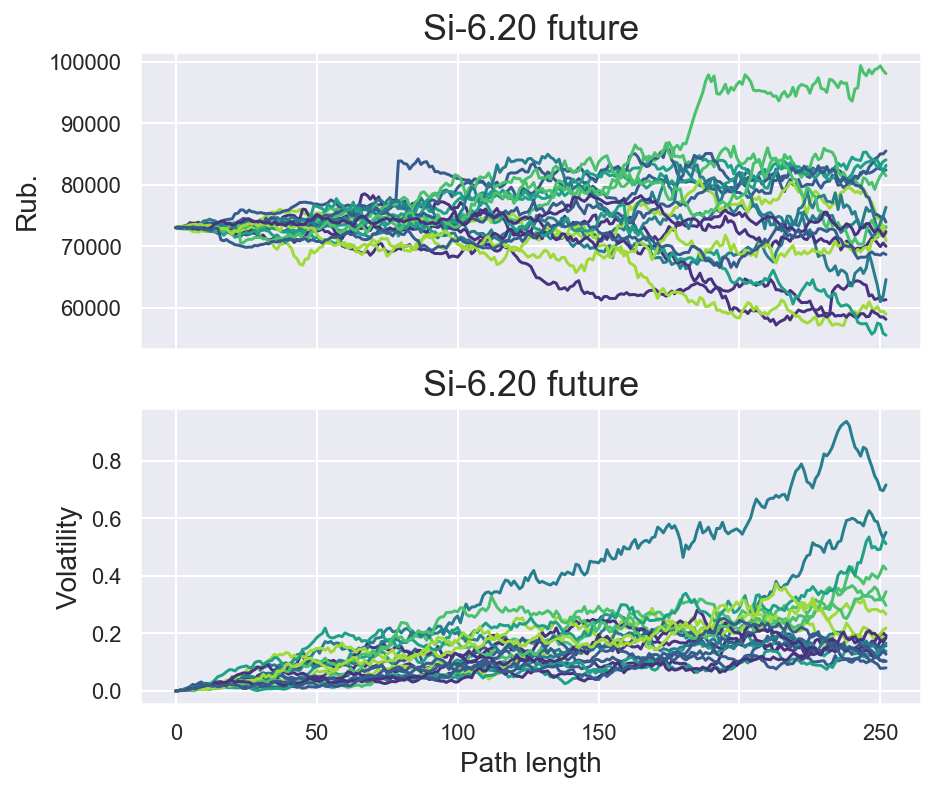

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = (7, 6))

ax1.set_title('Si-6.20 future', size = 18)
ax1.plot(S[:, :20])
ax1.set_ylabel('Rub.', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.plot(v[:, :20])
ax2.set_xlabel('Path length', size = 14)
ax2.set_ylabel('Volatility', size = 14)

# plt.savefig('Single model pictures/Bates single MC.pdf')
plt.show()

In [59]:
error = np.std(S) / np.sqrt(np.mean(S) * I)
print('Error of MC estimator = {0:.5%}'.format(error))

Error of MC estimator = 21.33266%


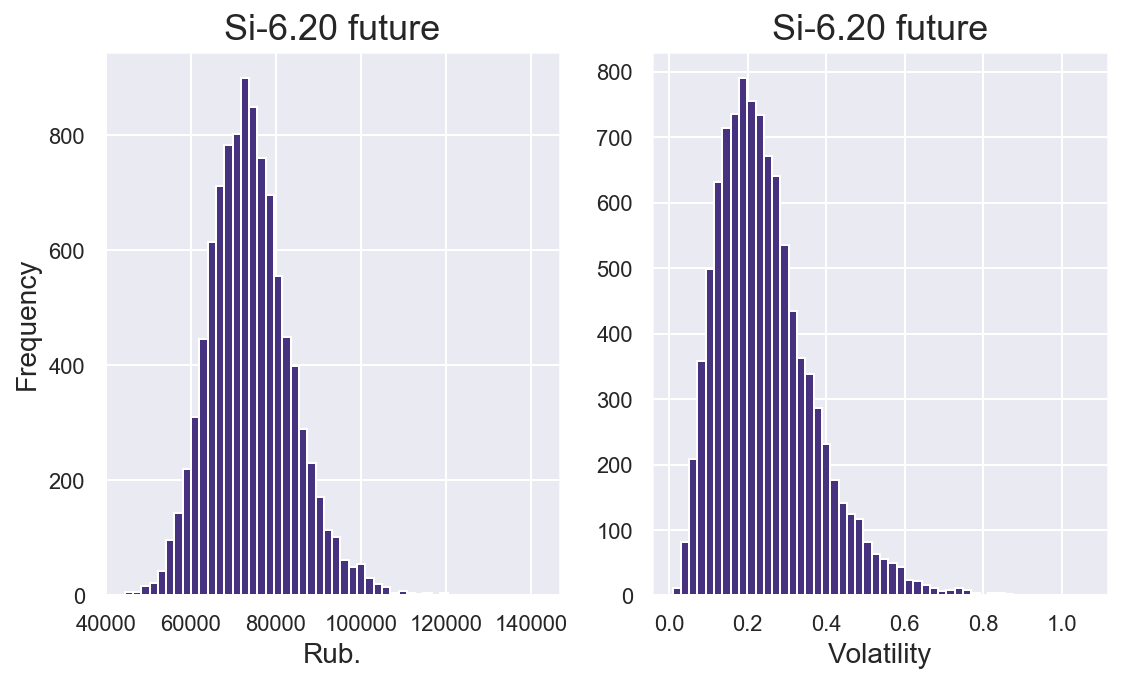

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 5))

ax1.set_title('Si-6.20 future', size = 18)
ax1.hist(S[-1], bins = 50)
ax1.set_xlabel('Rub.', size = 14)
ax1.set_ylabel('Frequency', size = 14)

ax2.set_title('Si-6.20 future', size = 18)
ax2.hist(v[-1], bins = 50)
ax2.set_xlabel('Volatility', size = 14)

# plt.savefig('Single model pictures/Bates single price distribution.pdf')
plt.show()

In [61]:
def print_statistics(a1, a2):

    sta1 = sp.stats.describe(a1)
    sta2 = sp.stats.describe(a2)
    print("%14s %14s %14s" % ('statistic', 'Price', 'Volatility'))
    print(45 * "-")
    print("%14s %14.3f %14.3f" % ('size', sta1[0], sta2[0]))
    print("%14s %14.3f %14.3f" % ('min', sta1[1][0], sta2[1][0]))
    print("%14s %14.3f %14.3f" % ('max', sta1[1][1], sta2[1][1]))
    print("%14s %14.3f %14.3f" % ('mean', sta1[2], sta2[2]))
    print("%14s %14.3f %14.3f" % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print("%14s %14.3f %14.3f" % ('skew', sta1[4], sta2[4]))
    print("%14s %14.3f %14.3f" % ('kurtosis', sta1[5], sta2[5]))

In [62]:
print_statistics(S[-1], v[-1])

     statistic          Price     Volatility
---------------------------------------------
          size      10000.000      10000.000
           min      44441.254          0.009
           max     142014.367          1.065
          mean      74146.864          0.246
           std       9673.919          0.123
          skew          0.561          1.051
      kurtosis          1.073          1.673


# All graphs in one

## Call price

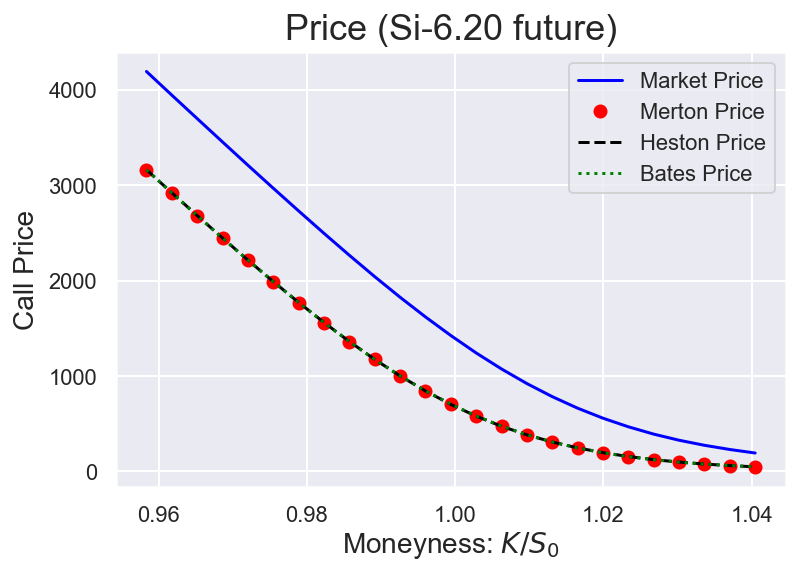

In [63]:
plt.plot(strikes / S0, prices, color = 'blue', label = 'Market Price')
plt.plot(strikes / S0, mertons_single, color = 'red', linestyle = ' ', marker = 'o', label = 'Merton Price')
plt.plot(strikes / S0, hestons_single, color = 'black', linestyle = '--', label = 'Heston Price')
plt.plot(strikes / S0, bates_single, color = 'green', linestyle = ':', label = 'Bates Price')


plt.title('Price (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('Call Price', size = 14)
plt.legend()

# plt.savefig('Single model pictures/All single prices.pdf')
plt.show()

## Implied volatility

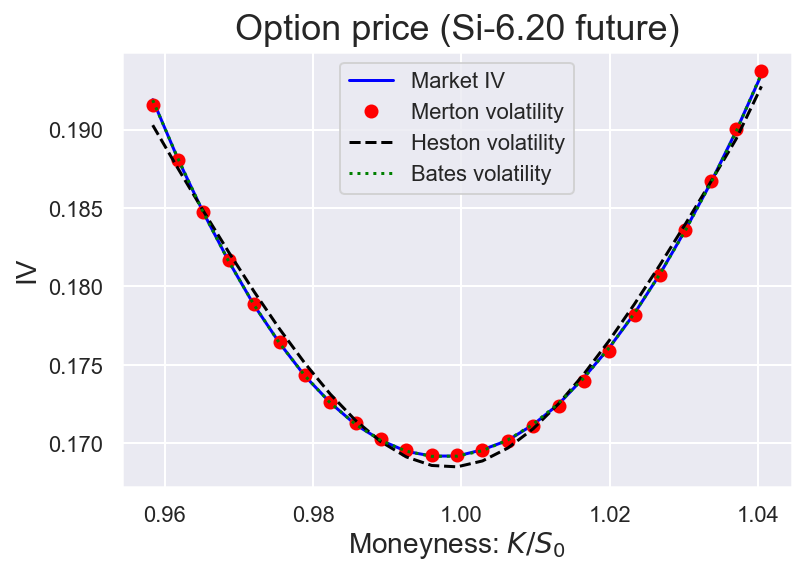

In [64]:
plt.plot(strikes / S0, implieds, color = 'blue', label = 'Market IV')
plt.plot(strikes / S0, mertons_single_iv, color = 'red', linestyle = ' ', marker = 'o', label = 'Merton volatility')
plt.plot(strikes / S0, hestons_single_iv, color = 'black', linestyle = '--', label = 'Heston volatility')
plt.plot(strikes / S0, bates_single_iv, color = 'green', linestyle = ':', label = 'Bates volatility')


plt.title('Option price (Si-6.20 future)', size = 18)
plt.xlabel('Moneyness: $K / S_{0}$', labelpad = 2, size = 14)
plt.ylabel('IV', size = 14)
plt.legend()

# plt.savefig('Single model pictures/All single iv.pdf')
plt.show()